In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
import tensorflow.keras.preprocessing as prep
# from sklearn.model_selection import train_test_split
from model import AugementedConvLSTM
import h5py
import itertools
from tqdm import tqdm

In [2]:
def get_Stack(i,idx_lst, end_index = 21185):
    X = np.empty((7,end_index,129,135))
    rand_field = np.array(np.load(rf"Data/r{i}.npy"))[:end_index,:,:]
    X[0,:,:,:] = rand_field
    X[1,:,:,:] = np.array(np.load(rf"Data/elev.npy"))[:end_index,:,:] if 1 not in idx_lst else rand_field
    X[2,:,:,:] = np.array(np.load(rf"Data/rhum.npy"))[:end_index,:,:] if 2 not in idx_lst else rand_field
    X[3,:,:,:] = np.array(np.load(rf"Data/pres.npy"))[:end_index,:,:] if 3 not in idx_lst else rand_field
    X[4,:,:,:] = np.array(np.load(rf"Data/uwnd.npy"))[:end_index,:,:] if 4 not in idx_lst else rand_field
    X[5,:,:,:] = np.array(np.load(rf"Data/vwnd.npy"))[:end_index,:,:] if 5 not in idx_lst else rand_field
    X[6,:,:,:] = np.array(np.load(rf"Data/omega.npy"))[:end_index,:,:] if 6 not in idx_lst else rand_field
    return X

def normalize(data):
    data = data - data.mean()
    data = data / data.std()
    return data

def set_data(X, Y, end_index):
    X_normalized = np.zeros((7, end_index, 129, 135))
    for i in range(7):
        X_normalized[i,] = normalize(X[i,])

    Y_normalized = normalize(Y)

    print("Mean of GCM Data: ",X[0,].mean())
    print("Variance of GCM Data: ",X[0,].std(),end="\n")

    print("Mean of Obseved Data: ",Y.mean())
    print("Variance of Obseved Data: ",Y.std(),end="\n")

    std_observed = Y.std()
    X = X_normalized.transpose(1,2,3,0)
    Y = Y_normalized.reshape(-1,129, 135, 1)
    return X, Y, std_observed

def data_generator(X,Y):
    time_steps = 4
    batch_size1 = 1
    generator = prep.sequence.TimeseriesGenerator(
        X, 
        Y.reshape(-1, 129, 135, 1),
        length=time_steps, 
        batch_size=batch_size1
        )
    return generator

def get_yy_hat(X, Y, model):
    generator = data_generator(X,Y)
    for xx, yy in itertools.islice(generator, 0, 1, 1):
        print(xx.shape, yy.shape)
    yy_hat = model.predict(generator)
    print(yy_hat.shape)
    return yy_hat

# def get_RMSE(X, Y, yy_hat):
#     generator = data_generator(X,Y)
#     rmse = np.zeros((129,135))
#     rmse_hist = np.zeros((yy_hat.shape[0],129,135))
#     cnt = 0
#     for xx, yy in tqdm(itertools.islice(generator, 0, None, 1)):
#         yy_pred = yy_hat[cnt].reshape(129,135)
#         yy = yy.reshape(129,135)
#         rmse += np.square(yy - yy_pred)
#         cnt += 1
#         rmse_hist[cnt-1] = np.sqrt(rmse/cnt)
#     rmse = np.sqrt(rmse/cnt)
#     # np.save(rf"Data/rmse_hist_{i}.npy", rmse_hist)
    
#     FileName = r"/home/uditbhatia/Documents/Sarth/Downscaling_AugmentedConvLSTM/03_Preprocess_Data/npy_Files/SRTM.npy"
#     mask = np.load(FileName)
#     indices = np.where(mask == 0)
#     rmse[indices] = np.nan
#     fig,ax = plt.subplots(1,2, figsize = (20,10))
#     sns.heatmap(np.flip(rmse, axis = 0), cmap = 'rainbow', ax =ax[0])
#     # ax.set_facecolor("lightgray")
#     ax[0].axis('off')
#     ax[1].boxplot(rmse[~np.isnan(rmse)], vert = False)
#     plt.suptitle(f"Random Field {i}", fontsize = 16)
#     plt.show()

#     return rmse

In [3]:
Aug_ConvLSTM_model = AugementedConvLSTM(
    projection_height = 129, 
    projection_width = 135,
    timesteps=4
    )
model = Aug_ConvLSTM_model.model(
    [32, 16, 16], 
    [9,5,3], 
    [64,32,1], 
    [9,3,5], 
    2
    )

2022-06-14 20:07:35.255810: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-14 20:07:38.278909: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9631 MB memory:  -> device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:18:00.0, compute capability: 7.5
2022-06-14 20:07:38.280731: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 9631 MB memory:  -> device: 1, name: GeForce RTX 2080 Ti, pci bus id: 0000:3b:00.0, compute capability: 7.5
2022-06-14 20:07:38.282468: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/r

In [4]:
model.load_weights('convlstm_weights_pr.h5')

# Investigating the behavior on Random Field

In [5]:
end_index = 1000
idx_lst = [1,2,3,4,5,6]
Y = np.load(rf"Data/IMD.npy")[:,:end_index,:,:]
X = get_Stack(1,idx_lst, end_index = end_index)
X, Y, std_observed = set_data(X, Y, end_index)
yy_hat = get_yy_hat(X, Y, model)

Mean of GCM Data:  0.005167930385080751
Variance of GCM Data:  2.744865499622606
Mean of Obseved Data:  1.0202210349420415
Variance of Obseved Data:  6.121113578963477
(1, 4, 129, 135, 7) (1, 129, 135, 1)


2022-06-14 16:52:08.711189: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201
2022-06-14 16:52:09.249064: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


(996, 129, 135, 1)


In [9]:
Y_hat = np.array(yy_hat).reshape(-1,129,135)
Y = np.load(rf"Data/IMD.npy")[:,4:end_index,:,:].reshape(-1,129,135)

In [10]:
Y_hat.shape

(996, 129, 135)

In [11]:
Y.shape

(996, 129, 135)

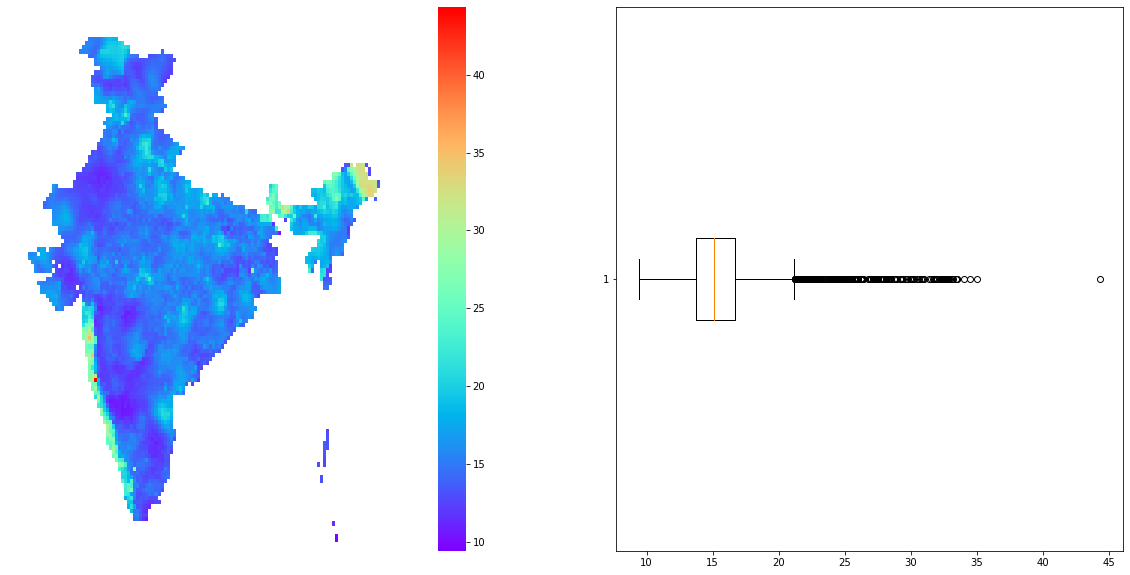

(Min, Max, Mean) = (9.429, 44.333, 15.727) mm/day


In [25]:

data = np.array(np.sqrt(np.sum(np.square(((Y_hat*Y.std())+Y.mean()) - Y), axis = 0)/Y_hat.shape[0]))
# data = np.array(np.mean(((Y_hat*Y.std())+Y.mean()) - Y, axis = 0))
FileName = r"Data/SRTM.npy"
mask = np.load(FileName)
indices = np.where(mask == 0)
data[indices] = np.nan
fig,ax = plt.subplots(1,2, figsize = (20,10))
sns.heatmap(np.flip(data, axis = 0), cmap = 'rainbow', ax =ax[0])
ax[0].axis('off')
ax[1].boxplot(data[~np.isnan(data)], vert = False)
plt.show()
print(f"(Min, Max, Mean) = ({round(np.nanmin(data),3)}, {round(np.nanmax(data),3)}, {round(np.nanmean(data),3)}) mm/day")

Y (Min, Max, Mean) = (0.0, 19.963, 3.497) mm/day


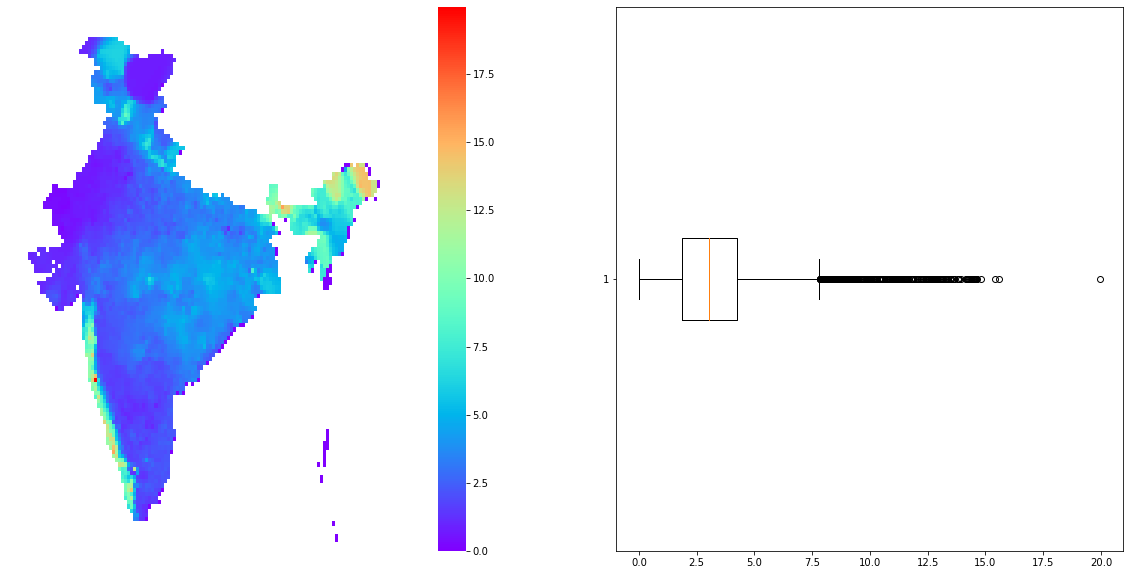

In [30]:
data = np.array(np.mean(Y, axis = 0))
FileName = r"Data/SRTM.npy"
mask = np.load(FileName)
indices = np.where(mask == 0)
data[indices] = np.nan
fig,ax = plt.subplots(1,2, figsize = (20,10))
sns.heatmap(np.flip(data, axis = 0), cmap = 'rainbow', ax =ax[0])
ax[0].axis('off')
ax[1].boxplot(data[~np.isnan(data)], vert = False)
print(f"Y (Min, Max, Mean) = ({round(np.nanmin(data),3)}, {round(np.nanmax(data),3)}, {round(np.nanmean(data),3)}) mm/day")
plt.show()

Y (Min, Max, Mean) = (4.8520002365112305, 7.706999778747559, 6.355000019073486) mm/day


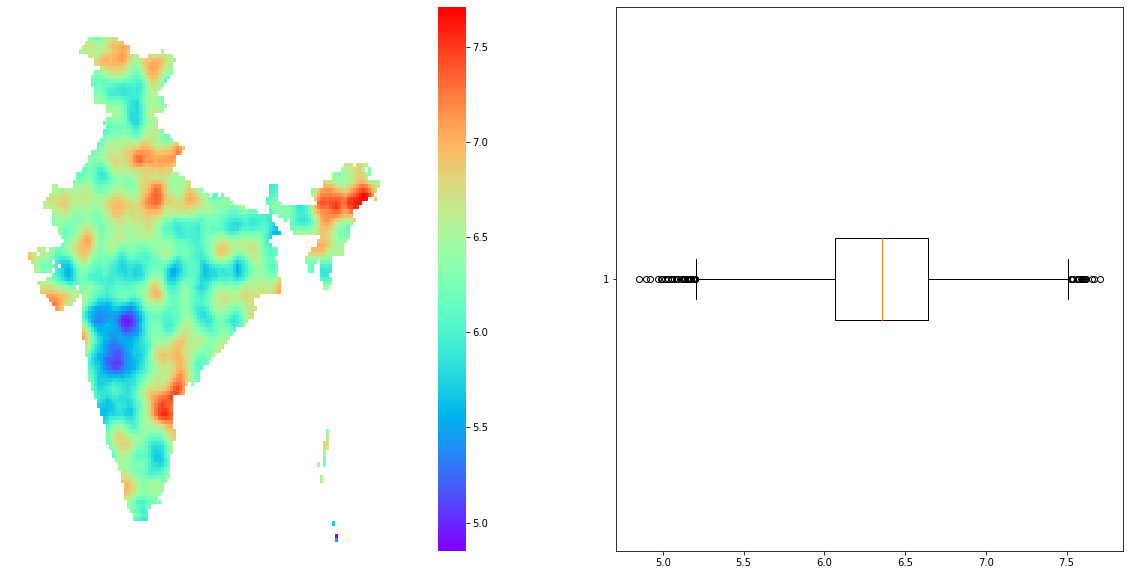

In [32]:
data = np.array(np.mean(((Y_hat*Y.std())+Y.mean()), axis = 0))
FileName = r"Data/SRTM.npy"
mask = np.load(FileName)
indices = np.where(mask == 0)
data[indices] = np.nan
fig,ax = plt.subplots(1,2, figsize = (20,10))
sns.heatmap(np.flip(data, axis = 0), cmap = 'rainbow', ax =ax[0])
ax[0].axis('off')
ax[1].boxplot(data[~np.isnan(data)], vert = False)
print(f"Y_hat (Min, Max, Mean) = ({round(np.nanmin(data),3)}, {round(np.nanmax(data),3)}, {round(np.nanmean(data),3)}) mm/day")
plt.show()

# Final Run on Random Field

Mean of GCM Data:  0.0020574424924732857
Variance of GCM Data:  2.750453246896165
Mean of Obseved Data:  0.8932552446925094
Variance of Obseved Data:  5.906902817390205
(1, 4, 129, 135, 7) (1, 129, 135, 1)


2022-06-14 20:09:31.832063: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 7605
2022-06-14 20:09:34.084095: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Running ptxas --version returned 32512
2022-06-14 20:09:35.165610: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: ptxas exited with non-zero error code 32512, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


(21181, 129, 135, 1)
Y (Min, Max, Mean) = (0.0, 19.211, 3.062) mm/day


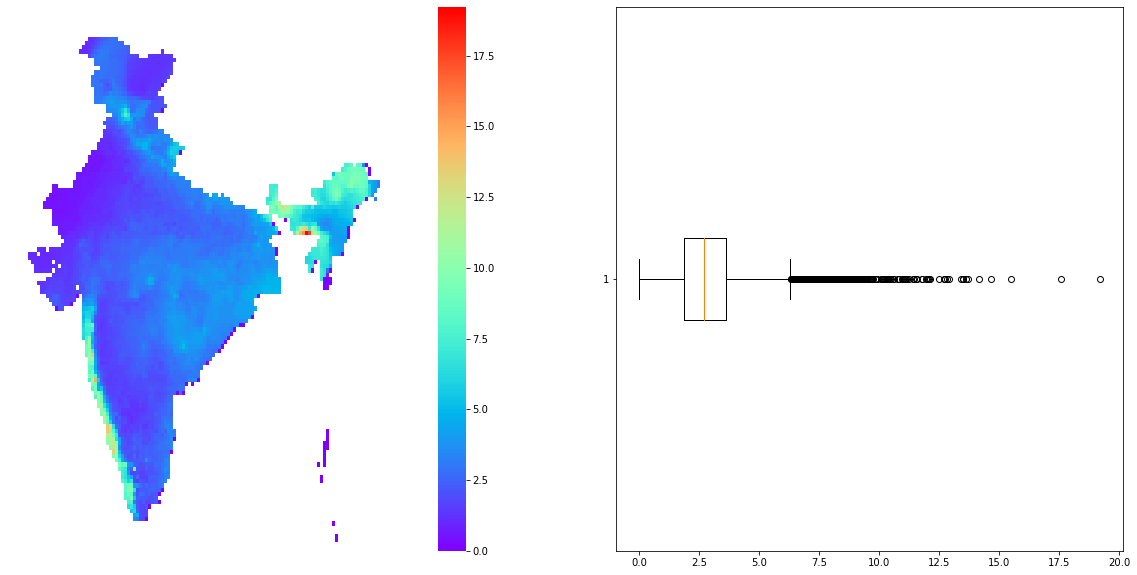

Y_hat (Min, Max, Mean) = (4.71999979019165, 6.609000205993652, 6.065000057220459) mm/day


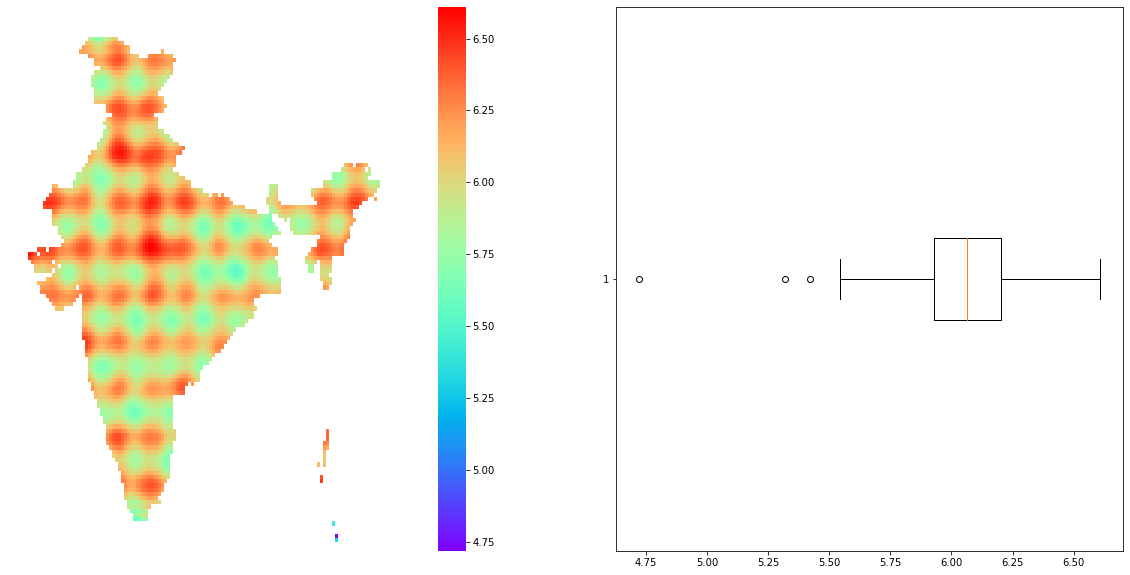

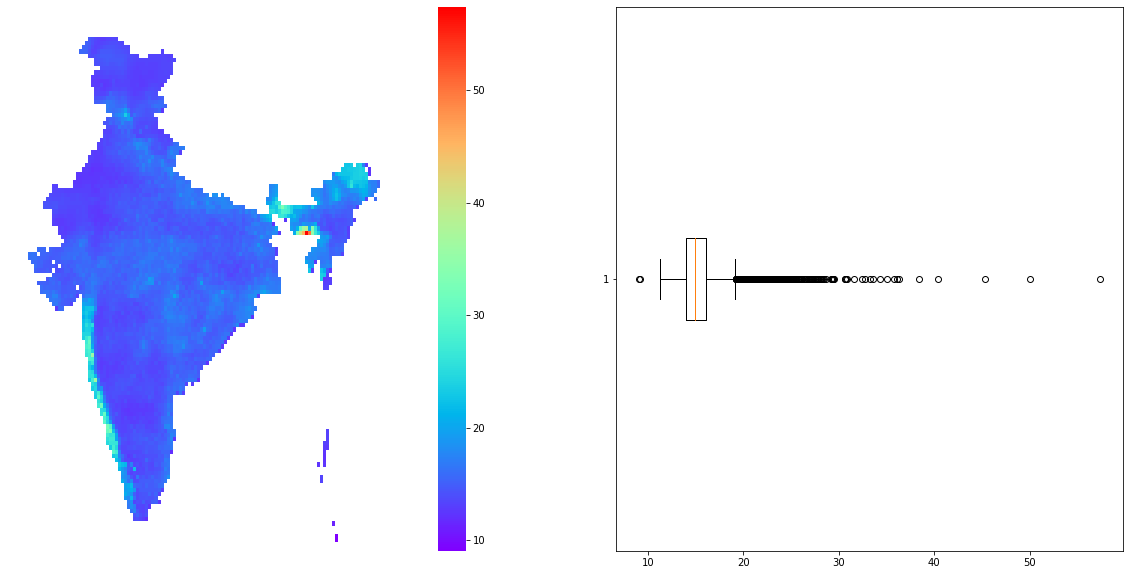

RMSE (Min, Max, Mean) = (9.069, 57.353, 15.462) mm/day


In [5]:
end_index = 21185
idx_lst = [1,2,3,4,5,6]
Y = np.load(rf"Data/IMD.npy")[:,:end_index,:,:]
X = get_Stack(1,idx_lst, end_index = end_index)
X, Y, std_observed = set_data(X, Y, end_index)
yy_hat = get_yy_hat(X, Y, model)

Y_hat = np.array(yy_hat).reshape(-1,129,135)
Y = np.load(rf"Data/IMD.npy")[:,4:end_index,:,:].reshape(-1,129,135)

data = np.array(np.mean(Y, axis = 0))
FileName = r"Data/SRTM.npy"
mask = np.load(FileName)
indices = np.where(mask == 0)
data[indices] = np.nan
fig,ax = plt.subplots(1,2, figsize = (20,10))
sns.heatmap(np.flip(data, axis = 0), cmap = 'rainbow', ax =ax[0])
ax[0].axis('off')
ax[1].boxplot(data[~np.isnan(data)], vert = False)
print(f"Y (Min, Max, Mean) = ({round(np.nanmin(data),3)}, {round(np.nanmax(data),3)}, {round(np.nanmean(data),3)}) mm/day")
plt.show()

data_scaled = np.array((Y_hat*Y.std())+Y.mean())
np.save(
    rf"rf1_yhat.npy",
    data_scaled
)
data = np.array(np.mean(((Y_hat*Y.std())+Y.mean()), axis = 0))
FileName = r"Data/SRTM.npy"
mask = np.load(FileName)
indices = np.where(mask == 0)
data[indices] = np.nan
fig,ax = plt.subplots(1,2, figsize = (20,10))
sns.heatmap(np.flip(data, axis = 0), cmap = 'rainbow', ax =ax[0])
ax[0].axis('off')
ax[1].boxplot(data[~np.isnan(data)], vert = False)
print(f"Y_hat (Min, Max, Mean) = ({round(np.nanmin(data),3)}, {round(np.nanmax(data),3)}, {round(np.nanmean(data),3)}) mm/day")
plt.show()

data = np.array(np.sqrt(np.sum(np.square(((Y_hat*Y.std())+Y.mean()) - Y), axis = 0)/Y_hat.shape[0]))
FileName = r"Data/SRTM.npy"
mask = np.load(FileName)
indices = np.where(mask == 0)
data[indices] = np.nan
fig,ax = plt.subplots(1,2, figsize = (20,10))
sns.heatmap(np.flip(data, axis = 0), cmap = 'rainbow', ax =ax[0])
ax[0].axis('off')
ax[1].boxplot(data[~np.isnan(data)], vert = False)
plt.show()
print(f"RMSE (Min, Max, Mean) = ({round(np.nanmin(data),3)}, {round(np.nanmax(data),3)}, {round(np.nanmean(data),3)}) mm/day")


Mean of GCM Data:  -0.0004330909459267981
Variance of GCM Data:  2.750289923143385
Mean of Obseved Data:  0.8932552446925094
Variance of Obseved Data:  5.906902817390205
(1, 4, 129, 135, 7) (1, 129, 135, 1)
(21181, 129, 135, 1)
Y (Min, Max, Mean) = (0.0, 19.211, 3.062) mm/day


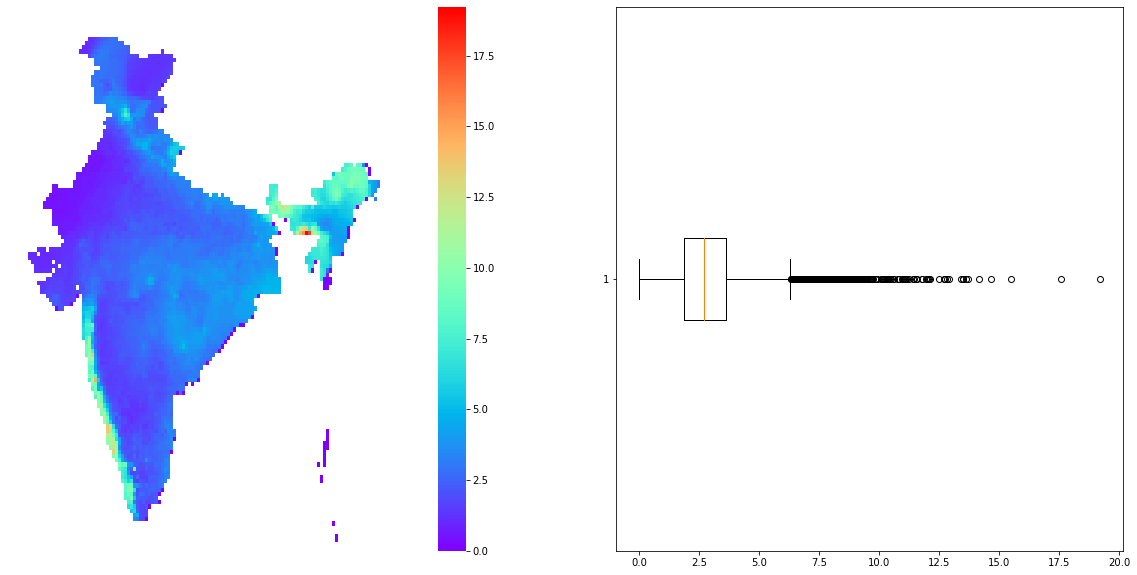

Y_hat (Min, Max, Mean) = (4.688000202178955, 6.59499979019165, 6.072000026702881) mm/day


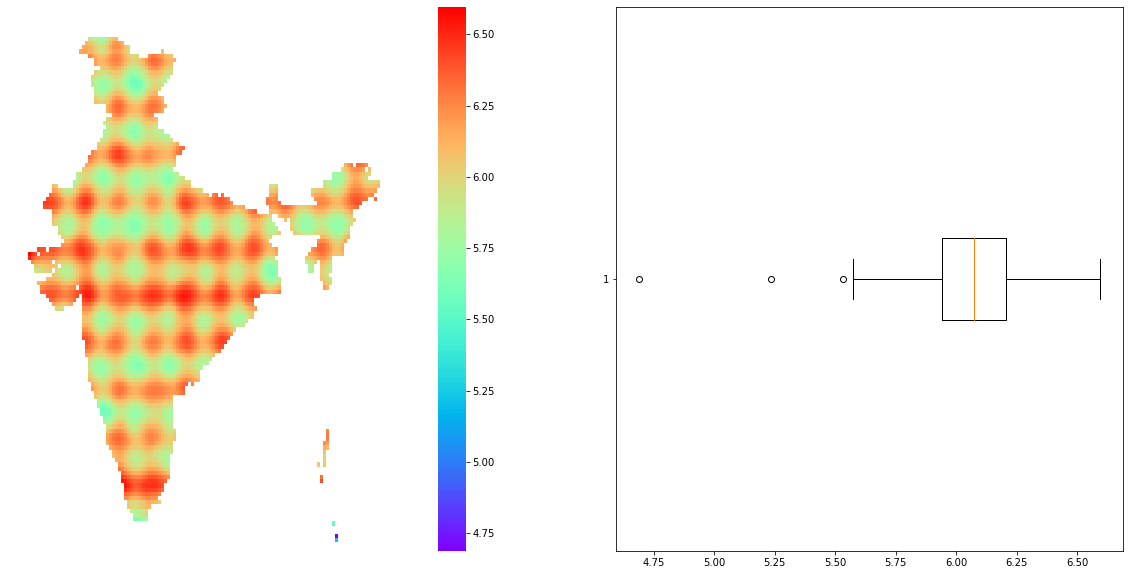

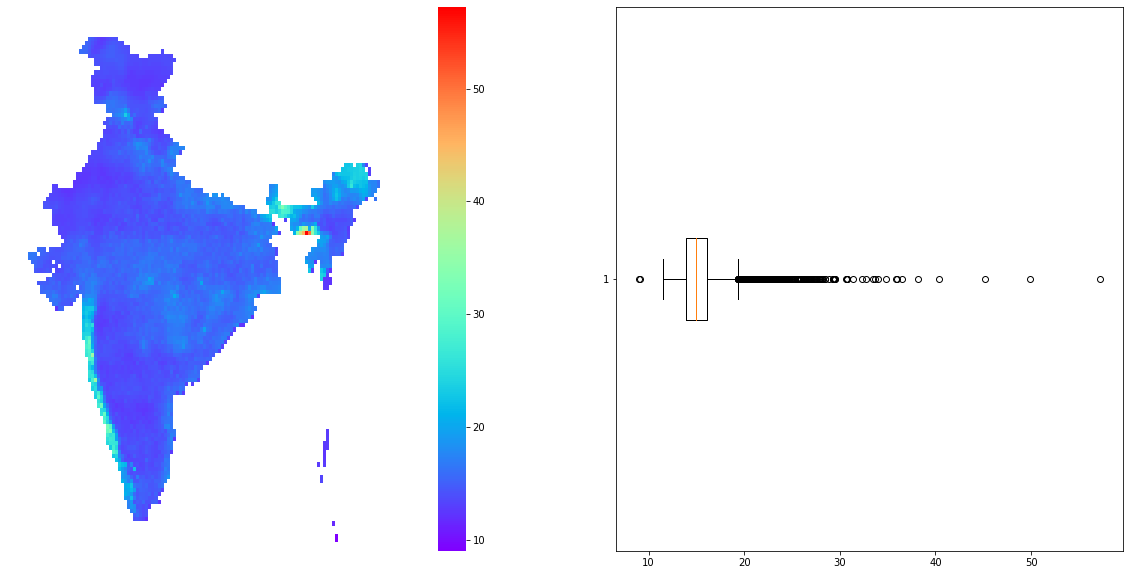

RMSE (Min, Max, Mean) = (8.998, 57.222, 15.468) mm/day


In [6]:
end_index = 21185
idx_lst = [1,2,3,4,5,6]
Y = np.load(rf"Data/IMD.npy")[:,:end_index,:,:]
X = get_Stack(2,idx_lst, end_index = end_index)
X, Y, std_observed = set_data(X, Y, end_index)
yy_hat = get_yy_hat(X, Y, model)

Y_hat = np.array(yy_hat).reshape(-1,129,135)
Y = np.load(rf"Data/IMD.npy")[:,4:end_index,:,:].reshape(-1,129,135)

data = np.array(np.mean(Y, axis = 0))
FileName = r"Data/SRTM.npy"
mask = np.load(FileName)
indices = np.where(mask == 0)
data[indices] = np.nan
fig,ax = plt.subplots(1,2, figsize = (20,10))
sns.heatmap(np.flip(data, axis = 0), cmap = 'rainbow', ax =ax[0])
ax[0].axis('off')
ax[1].boxplot(data[~np.isnan(data)], vert = False)
print(f"Y (Min, Max, Mean) = ({round(np.nanmin(data),3)}, {round(np.nanmax(data),3)}, {round(np.nanmean(data),3)}) mm/day")
plt.show()

data_scaled = np.array((Y_hat*Y.std())+Y.mean())
np.save(
    rf"rf2_yhat.npy",
    data_scaled
)
data = np.array(np.mean(((Y_hat*Y.std())+Y.mean()), axis = 0))
FileName = r"Data/SRTM.npy"
mask = np.load(FileName)
indices = np.where(mask == 0)
data[indices] = np.nan
fig,ax = plt.subplots(1,2, figsize = (20,10))
sns.heatmap(np.flip(data, axis = 0), cmap = 'rainbow', ax =ax[0])
ax[0].axis('off')
ax[1].boxplot(data[~np.isnan(data)], vert = False)
print(f"Y_hat (Min, Max, Mean) = ({round(np.nanmin(data),3)}, {round(np.nanmax(data),3)}, {round(np.nanmean(data),3)}) mm/day")
plt.show()

data = np.array(np.sqrt(np.sum(np.square(((Y_hat*Y.std())+Y.mean()) - Y), axis = 0)/Y_hat.shape[0]))
FileName = r"Data/SRTM.npy"
mask = np.load(FileName)
indices = np.where(mask == 0)
data[indices] = np.nan
fig,ax = plt.subplots(1,2, figsize = (20,10))
sns.heatmap(np.flip(data, axis = 0), cmap = 'rainbow', ax =ax[0])
ax[0].axis('off')
ax[1].boxplot(data[~np.isnan(data)], vert = False)
plt.show()
print(f"RMSE (Min, Max, Mean) = ({round(np.nanmin(data),3)}, {round(np.nanmax(data),3)}, {round(np.nanmean(data),3)}) mm/day")

Mean of GCM Data:  0.0017826523740682022
Variance of GCM Data:  2.7478070621890383
Mean of Obseved Data:  0.8932552446925094
Variance of Obseved Data:  5.906902817390205
(1, 4, 129, 135, 7) (1, 129, 135, 1)
(21181, 129, 135, 1)
Y (Min, Max, Mean) = (0.0, 19.211, 3.062) mm/day


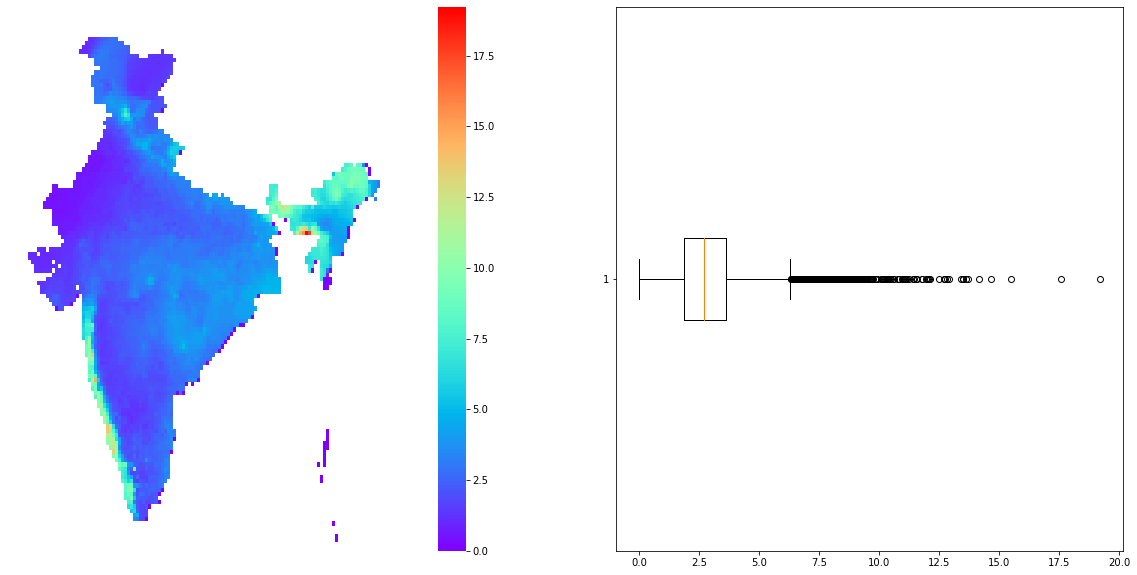

Y_hat (Min, Max, Mean) = (4.552999973297119, 6.565999984741211, 6.039000034332275) mm/day


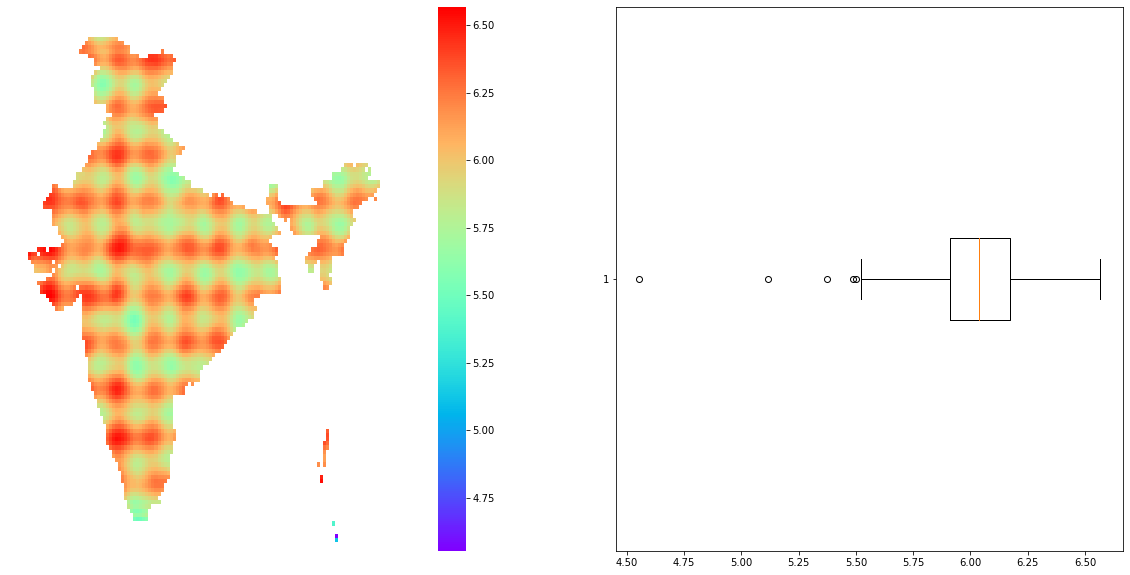

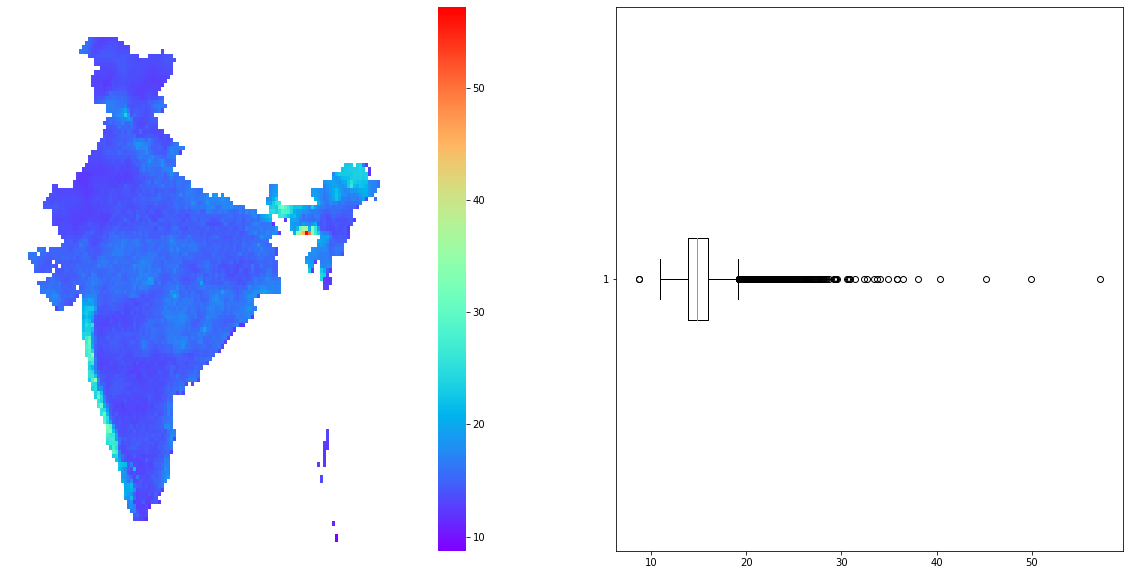

RMSE (Min, Max, Mean) = (8.732, 57.19, 15.415) mm/day


In [7]:
end_index = 21185
idx_lst = [1,2,3,4,5,6]
Y = np.load(rf"Data/IMD.npy")[:,:end_index,:,:]
X = get_Stack(3,idx_lst, end_index = end_index)
X, Y, std_observed = set_data(X, Y, end_index)
yy_hat = get_yy_hat(X, Y, model)

Y_hat = np.array(yy_hat).reshape(-1,129,135)
Y = np.load(rf"Data/IMD.npy")[:,4:end_index,:,:].reshape(-1,129,135)

data = np.array(np.mean(Y, axis = 0))
FileName = r"Data/SRTM.npy"
mask = np.load(FileName)
indices = np.where(mask == 0)
data[indices] = np.nan
fig,ax = plt.subplots(1,2, figsize = (20,10))
sns.heatmap(np.flip(data, axis = 0), cmap = 'rainbow', ax =ax[0])
ax[0].axis('off')
ax[1].boxplot(data[~np.isnan(data)], vert = False)
print(f"Y (Min, Max, Mean) = ({round(np.nanmin(data),3)}, {round(np.nanmax(data),3)}, {round(np.nanmean(data),3)}) mm/day")
plt.show()

data_scaled = np.array((Y_hat*Y.std())+Y.mean())
np.save(
    rf"rf3_yhat.npy",
    data_scaled
)
data = np.array(np.mean(((Y_hat*Y.std())+Y.mean()), axis = 0))
FileName = r"Data/SRTM.npy"
mask = np.load(FileName)
indices = np.where(mask == 0)
data[indices] = np.nan
fig,ax = plt.subplots(1,2, figsize = (20,10))
sns.heatmap(np.flip(data, axis = 0), cmap = 'rainbow', ax =ax[0])
ax[0].axis('off')
ax[1].boxplot(data[~np.isnan(data)], vert = False)
print(f"Y_hat (Min, Max, Mean) = ({round(np.nanmin(data),3)}, {round(np.nanmax(data),3)}, {round(np.nanmean(data),3)}) mm/day")
plt.show()

data = np.array(np.sqrt(np.sum(np.square(((Y_hat*Y.std())+Y.mean()) - Y), axis = 0)/Y_hat.shape[0]))
FileName = r"Data/SRTM.npy"
mask = np.load(FileName)
indices = np.where(mask == 0)
data[indices] = np.nan
fig,ax = plt.subplots(1,2, figsize = (20,10))
sns.heatmap(np.flip(data, axis = 0), cmap = 'rainbow', ax =ax[0])
ax[0].axis('off')
ax[1].boxplot(data[~np.isnan(data)], vert = False)
plt.show()
print(f"RMSE (Min, Max, Mean) = ({round(np.nanmin(data),3)}, {round(np.nanmax(data),3)}, {round(np.nanmean(data),3)}) mm/day")

In [18]:
import netCDF4 as nc
import pandas as pd
import numpy as np
import xarray as xr
# import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import os
import glob

In [15]:
lat_bnds, lon_bnds = [6.5, 38.5], [66.5, 100]
projection_dimension = [129, 135]
lat_lst = np.linspace(lat_bnds[0], lat_bnds[1], projection_dimension[0])
lon_lst = np.linspace(lon_bnds[0], lon_bnds[1], projection_dimension[1])

129 135


In [22]:
for i in [1,2,3]:
    pr_values = np.load(rf"rf{i}_yhat.npy").reshape(-1,129,135)
    Y = np.load(rf"Data/IMD.npy")[:,4:,:,:].reshape(-1,129,135)
    pr_values = (pr_values*Y.std())+Y.mean()
    print(pr_values.shape)

    dates = pd.date_range(start = '1948-01-05', end = '2005-12-31')
    print((len(dates),len(lat_lst),len(lon_lst)))

    ds = xr.Dataset({
            'pr': xr.DataArray(
                data = pr_values.reshape(len(dates), len(lat_lst), len(lon_lst)),
                dims = ['time', 'lat', 'lon'],
                coords = {
                    'time': dates,
                    'lat': lat_lst,
                    'lon': lon_lst
                },
                attrs = {'units':'mm/day'}
            )
        }
    )
    # ds
    ds.to_netcdf(rf"NC_Files/r{i}.nc")
    print(rf"NC_Files/r{i}.nc")

(21181, 129, 135)
(21181, 129, 135)
NC_Files/r1.nc
(21181, 129, 135)
(21181, 129, 135)
NC_Files/r2.nc
(21181, 129, 135)
(21181, 129, 135)
NC_Files/r3.nc
